<a href="https://colab.research.google.com/github/HugoKD/byoRNA/blob/main/ByoRna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random as rd

**Réferences :** <br>
Pour la partie DSP  :

*  Model-based design and control of a small-scale integrated
continuous end-to-end mAb platform
*  Modeling and Simulation of Upstream and
Downstream Processes for Monoclonal
Antibody Production

Pour la partie USP :

*   *équations de monod*

## POO

On va faire un poo en python pour simuler le process de filtration. Chaque filtre possède une certaine affinité, des certaines caractéristiques. On veut arriver à un résultat optimal en un nombre d'étapes minimales -> programation sous contraintes. On veut un nombre de step min et un quantité d'ARN maximale (ou alors une pureté maximale). Pour l'instant on ne considère que la taille de la molécule d'interêt. <br><br>
De base on part d'une population de x% d'ARN,y% ADN, z% débris, w% de protéines, v% de virus et p% de petites molécules -> fixé. La masse totale de la mixture,elle n'est pas fixée. Cf UPS

#### USP

In [5]:
class USP:
    def __init__(self, mu_max=0.4, K_s=0.9, Y_E=0.8, q_G=0.1, q_O=0.5, m=0.01, G0=20, X0=0.4, E0=0, O0=100):
        self.mu_max = mu_max  # taux de croissance spécifique maximal (h^-1)
        self.K_s = K_s  # constante de saturation de Monod pour le glucose (g/L)
        self.Y_E = Y_E  # yield de l'éthanol sur le glucose (g/g)
        self.q_G = q_G  # taux spécifique de consommation de glucose (g/g.h)
        self.q_O = q_O  # taux spécifique de consommation d'oxygène (%/g.h)
        self.m = m  # taux de maintenance (h^-1)
        # concentrations initiales
        self.G0 = G0  # c_i de glucose (g/L)
        self.X0 = X0  # c_i de biomasse (g/L)
        self.E0 = E0  # c_i d'éthanol (g/L)
        self.O0 = O0  # c_i d'oxygène (%)
        self.solution = None  # Variable pour stocker la solution

    def model(self, y, t):
        G, X, E, O = y
        mu = self.mu_max * (G / (self.K_s + G))
        dG_dt = -mu * X - self.q_G * X
        dX_dt = (mu - self.m) * X
        dE_dt = self.Y_E * (self.q_G - mu) * X
        dO_dt = -self.q_O * X
        return [dG_dt, dX_dt, dE_dt, dO_dt]

    def get_solution(self, t_end=30, n=100, plot=True):
        t = np.linspace(0, t_end, n)  # en heure
        y0 = [self.G0, self.X0, self.E0, self.O0]
        # Résoudre les équa diffs avec odeint
        self.solution = odeint(self.model, y0, t)
        G, X, E, O = self.solution.T
        if plot:
            # Créer le graphique
            plt.figure(figsize=(10, 6))
            plt.plot(t, G, label='Glucose')
            plt.plot(t, X, label='Biomasse')
            plt.plot(t, O, label='Oxygène (%)')
            plt.xlabel('Temps (h)')
            plt.ylabel('Concentration (g/L)')
            plt.title('Modèle de Sonnleitner et Käppeli et de Monod')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
          return G, X, E, O

    def get_masse_X(self, taille):  # taille en L
        if self.solution is None:
            self.get_solution(plot=False)
        G, X, E, O = self.solution.T
        return X[-1] * taille  # return g de biomasse

In [6]:
usp = USP()

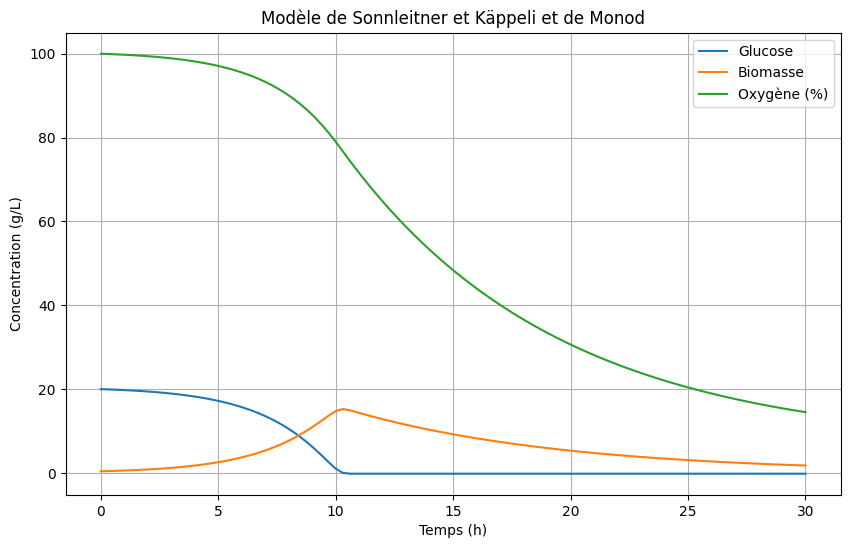

In [7]:
usp.get_solution(plot=True)

#### Filtration par taille ou par charge

In [8]:
class DSP:
    def __init__(self, feed):
        self.feed = feed

    def get_mean(self, feed):
      s = 0
      for molecule in feed:
        s += molecule['size']
      return s/len(feed)

    def simulate(self, transform ,type_,filter_size, filter_charge,type_chromatography,display = False ):
        # Perform filtration
        filtration = Filtration(self.feed, filter_size=filter_size,filter_charge = filter_charge)
        filtration.perform_filtration(type_ = type_, type_chromatography =type_chromatography , transform = transform)
        filtration_results = filtration.get_results()
        if display :
          print(f"initial : {self.feed}")
          print(f"filtrat: {filtration_results['filtrat']}")
          print(f"residu: {filtration_results['residu']}")
          return self.feed, filtration_results['filtrat'], filtration_results['residu']
        else :
          return self.feed, filtration_results['filtrat'], filtration_results['residu']

    def visu(self,type_,filter_size, filter_charge,type_chromatography,transform):
        i,f,r = self.simulate(transform = transform,type_ = type_,filter_size = filter_size, filter_charge = filter_charge,type_chromatography = type_chromatography)
        data = {'initial' : i, 'filtrat' : f, "residu" : r}
        types = ["DNA", "RNA", "protein", "virus", "tiny_mol", "debris"]
        initial_weights = [item["poids"] for item in data["initial"]]
        filtrat_weights = [item["poids"] for item in data["filtrat"]]
        residu_weights = [next((item["poids"] for item in data["residu"] if item["type"] == t), 0) for t in types]

        # Creating the bar chart
        bar_width = 0.25
        x = np.arange(len(types))

        plt.figure(figsize=(10, 6))
        plt.bar(x - bar_width, initial_weights, width=bar_width, label='Initial')
        plt.bar(x, filtrat_weights, width=bar_width, label='Filtrat')
        plt.bar(x + bar_width, residu_weights, width=bar_width, label='Residu')

        plt.xlabel('Type')
        plt.ylabel('Poids')
        plt.title('Poids par Type pour Initial, Filtrat et Residu')
        plt.xticks(x, types)
        plt.legend()
        plt.show()
        return self.feed

In [9]:
##V.1 simpliste sans considération physique
### Deux comportements différents des filtres basés sur la selectivité des pores : fonction logistique ou fonction de ""passage""" voir si autre loi de passage, plus réaliste

class Filtration:
    def __init__(self, feed,filter_size,filter_charge):
        self.feed = feed #notre mixture qu'on filtre avec x% d'ARN,y% ADN, z% débrit, w% de protéine, v% de virus et p% de petites molécules
        self.filter_size = filter_size #1 seul parametre = taille du filtre, en nm
        self.filter_charge = filter_charge
        self.filtrat = [] #fraction du mélange qui a passé à travers le filtre
        self.residu = [] #fraction du mélange qui n'a pas passé à travers le filtre

    def perform_filtration(self, type_,type_chromatography,  threshold=0.1 ,k = 5, k_inf = 4.2, c_inf = 1.3,k_sup = 15, c_sup = 1.1,transform = False): # k = degré de la pente, et c = pnt d'inflexion ou p = 0.5, ajoute d'aléatoire "controlé"
        feed = []
        if type_chromatography == 'size':
          for molecule in self.feed:
              size = molecule['size']
              r =   size /self.filter_size
              if size <= self.filter_size:
                  if type_ == 'logistique':
                    p = 1 / (1 + exp(-k_inf * (c_inf - r))) #fonction logistique avec une forte augmentation de la proba de passer le filtre quand la taille diminue
                  elif type_ == 'passage':
                    p = (1 - (size / self.filter_size) ** 2) ** 1
                  else :
                    raise(ValueError("Type de filtre inconnu"))
                  poids_residu, poids_filtrat = molecule["poids"]*(1-p),molecule["poids"]*p
                  mol_filtrat,mol_residu = molecule.copy(),molecule.copy()
                  mol_filtrat["poids"] = poids_filtrat
                  mol_residu["poids"] = poids_residu
                  self.filtrat.append(mol_filtrat)
                  self.residu.append(mol_residu)
              else:
                  if type_ == 'logistique':
                    p = 1- 1 / (1 + math.exp(-k_sup * (r - c_sup)))  #très forte diminution de la proba de passer le filtre quand la taille augmente
                  elif type_ == 'passage':
                    p = 0
                  else :
                    raise(ValueError("Type de filtre inconnu"))
                  poids_residu, poids_filtrat = molecule["poids"]*(1-p),molecule["poids"]*p
                  mol_filtrat,mol_residu =  molecule.copy(),molecule.copy()
                  mol_filtrat["poids"] = poids_filtrat
                  mol_residu["poids"] = poids_residu
                  self.filtrat.append(mol_filtrat)
                  self.residu.append(mol_residu)
              if transform :
                self.feed = self.filtrat
        elif type_chromatography == "charge":
             for molecule in self.feed:
                  charge = molecule['charge']
                  x = charge * self.filter_charge
                  p = 1 / (1 + np.exp((x - threshold)))
                  poids_residu, poids_filtrat = molecule["poids"]*(1-p),molecule["poids"]*p
                  mol_filtrat,mol_residu = molecule.copy(),molecule.copy()
                  mol_filtrat["poids"] = poids_filtrat
                  mol_residu["poids"] = poids_residu
                  self.filtrat.append(mol_filtrat)
                  self.residu.append(mol_residu)
                  if transform :
                      self.feed = self.filtrat
        else :
          raise(ValueError("type de chromatographie inconnu"))


    def get_results(self):
        return {
            'filtrat': self.filtrat,
            'residu': self.residu
        }


masse totale USP de 177.0787413970911
['DNA -1', 'RNA -1', 'protein 2', 'virus 0', 'tiny_mol -1', 'debris 0']


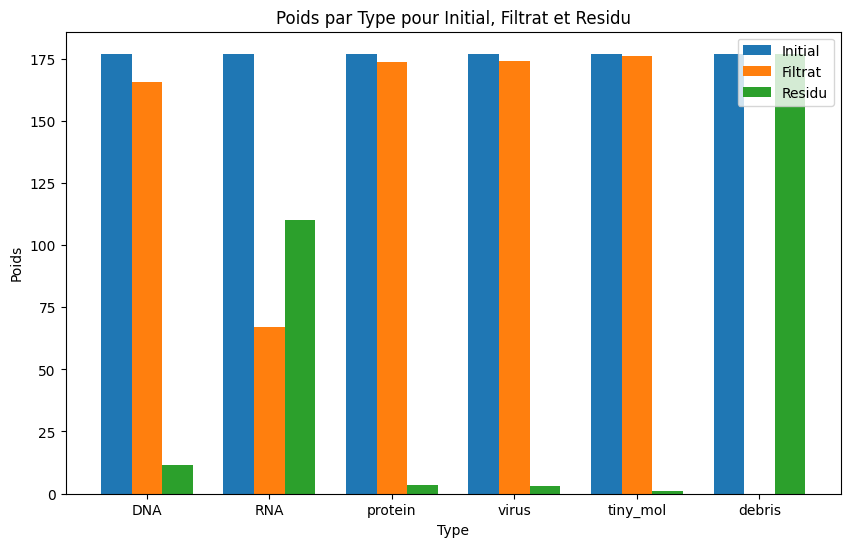

[{'type': 'DNA', 'size': 200, 'pourcentage': 0.045, 'poids_unitaire': 1.0956e-19, 'poids': 177.0787413970911, 'charge': -1}, {'type': 'RNA', 'size': 340, 'pourcentage': 0.045, 'poids_unitaire': 1.9189600000000002e-19, 'poids': 177.0787413970911, 'charge': -1}, {'type': 'protein', 'size': 108, 'pourcentage': 0.1, 'poids_unitaire': 1.9720800000000002e-20, 'poids': 177.0787413970911, 'charge': 2}, {'type': 'virus', 'size': 100, 'pourcentage': 0.01, 'poids_unitaire': 1.66e-13, 'poids': 177.0787413970911, 'charge': 0}, {'type': 'tiny_mol', 'size': 10, 'pourcentage': 0.01, 'poids_unitaire': 2.988e-22, 'poids': 177.0787413970911, 'charge': -1}, {'type': 'debris', 'size': 1000, 'pourcentage': 0.8, 'poids_unitaire': 1.66e-18, 'poids': 177.0787413970911, 'charge': 0}]


In [13]:
dalton_to_gram = 1.66e-24

feed = [
    {'type': 'DNA', 'size': 200, 'pourcentage': 0.045, 'poids_unitaire': 200 * 330 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'RNA', 'size': 340, 'pourcentage': 0.045, 'poids_unitaire': 340 * 340 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'protein', 'size': 108, 'pourcentage': 0.10, 'poids_unitaire': 108 * 110 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : 2},
    {'type': 'virus', 'size': 100, 'pourcentage': 0.01, 'poids_unitaire': 100 * 10**9 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : 0},
    {'type': 'tiny_mol', 'size': 10, 'pourcentage': 0.01, 'poids_unitaire': 1 * 180 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : -1},
    {'type': 'debris', 'size': 1000, 'pourcentage': 0.8, 'poids_unitaire': 200 * 5000 * dalton_to_gram, 'poids' : usp.get_masse_X(100), 'charge' : 0}
]


print(f"masse totale USP de {usp.get_masse_X(100)}")
print([f"{molecule['type']} {molecule['charge']}" for molecule in feed])
process = DSP(feed)
s = process.visu(type_ = 'logistique',filter_size= 300, filter_charge = -1,type_chromatography='size', transform = True)


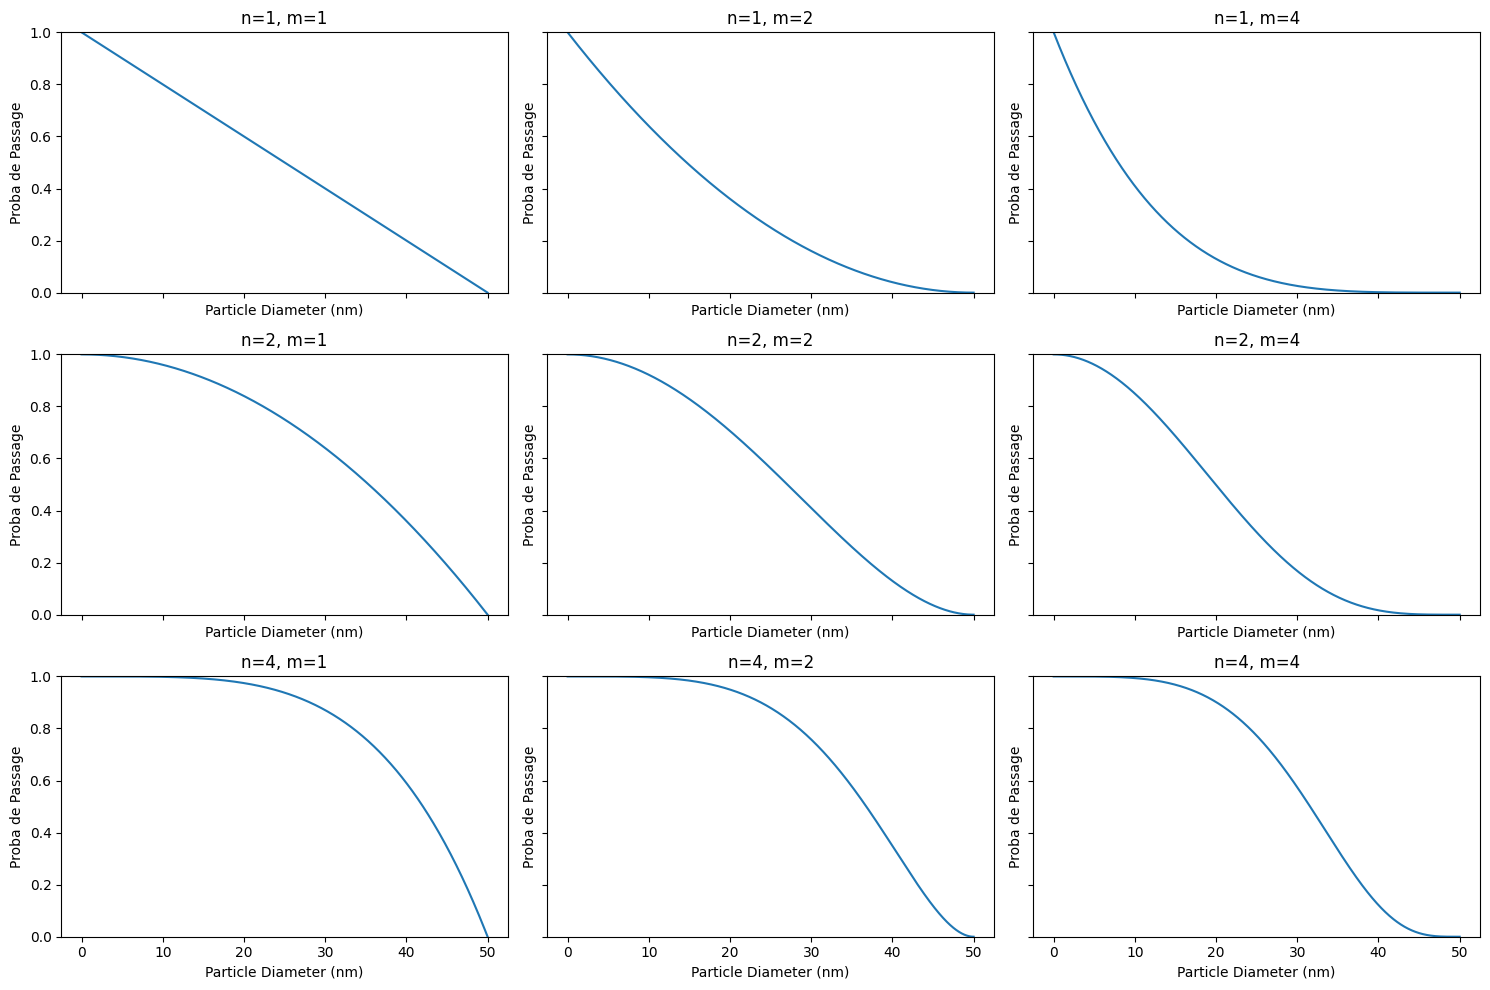

In [ ]:
## Influence des paramètres n et m sur la fonction de passage

def passage_probability(pore_diameter, particle_diameter, n, m):
    return (1 - (particle_diameter / pore_diameter) ** n) ** m

pore_diameter = 50  # 50 nm

particle_diameters = np.linspace(0, 50, 1000)  # De 1 nm à 100 nm

# Différentes valeurs de n et m
ns = [1, 2, 4]
ms = [1, 2, 4]

fig, ax = plt.subplots(len(ns), len(ms), figsize=(15, 10), sharex=True, sharey=True)

for i, n in enumerate(ns):
    for j, m in enumerate(ms):
        probabilities = [passage_probability(pore_diameter, d, n, m) for d in particle_diameters]
        ax[i, j].plot(particle_diameters, probabilities)
        ax[i, j].set_title(f'n={n}, m={m}')
        ax[i, j]
        ax[i, j].set_ylim(0, 1)
        ax[i, j].set_xlabel('Particle Diameter (nm)')
        ax[i, j].set_ylabel('Proba de Passage')

plt.tight_layout()
plt.show()


#### Modélisation chromato basée sur les équations de transfert de masse

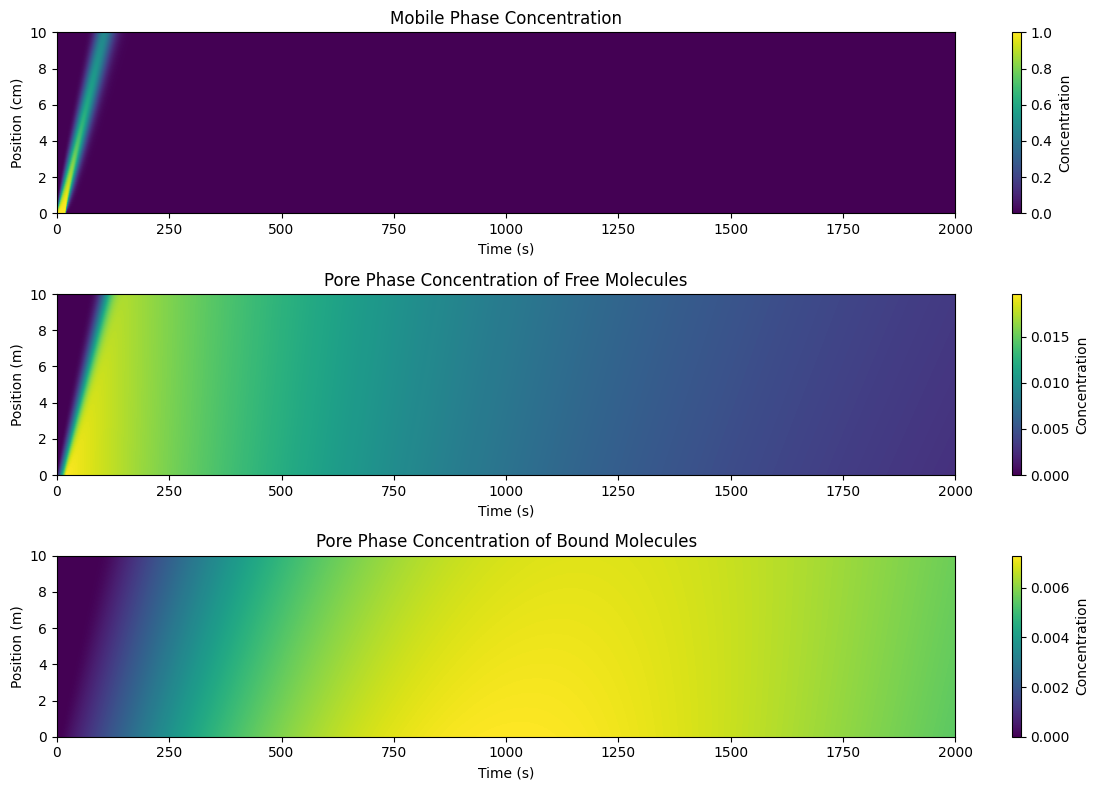

In [17]:
import numpy as np
import matplotlib.pyplot as plt

class Filtration:
    def __init__(self, feed, filter_size):
        self.feed = feed
        self.filter_size = filter_size

class Chromatography(Filtration):
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity):
        super().__init__(feed, filter_size)

        self.L = L # longueur de la colonne (cm)
        self.T = T # temps de la chromatographie
        self.v = v # velocité linéaire de la phase mobile (m/s)
        self.D = D # coefficient de diffusion  (m^2/s)
        self.Nx = Nx # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration # durée d'alimentation
        self.pulse_concentration = pulse_concentration # concentration de l'alimentation
        self.target_molecule = target_molecule # molécule d'interêt
        self.particle_size = particle_size
        self.molecule_size = molecule_size
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity
        self.affinity = affinity

        self.z = np.linspace(0, L, Nx)

        # Initialize concentration arrays
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        # Initial conditions
        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        # Transport and production rates
        self.R = self.calculate_R
        self.Rp = self.calculate_Rp
        self.Rq = self.calculate_Rq

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_R(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rp(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rq(self, c, cp, q):
        return self.affinity * (cp - q) * (self.particle_size / (self.particle_size + self.molecule_size))

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.R(self.c, self.cp, self.q)
            dcp_dt = self.Rp(self.c, self.cp, self.q)
            dq_dt = self.Rq(self.c, self.cp, self.q)

            self.c += dc_dt * self.dt
            self.cp += dcp_dt * self.dt
            self.q += dq_dt * self.dt

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()

    def plot_results(self,nbr_simu):
        time_points = np.linspace(0, self.T, len(self.c_history))

        size  = self.molecule_size * i * 10
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.title(f'Mobile Phase Concentration for molecule size {size}')
        plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(2, 1, 2)
        plt.title(f'Pore Phase Concentration of Free molecule size {self.charges[i]}')
        plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()


# Parameters
L = 10
T = 2000.0
v = 0.1
D = 0.01
Nx = 100
Nt = 100000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0
particle_size = .01  # Example particle size
molecule_size = 0.0001  # Example molecule size
temperature = 298.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 0.9  # Example solvent viscosity (arbitrary units)
affinity = 0.001  # Example affinity constant
size = [.0001,.001,.01]
# Instantiate and run chromatography
chromatography = Chromatography(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity)
chromatography.perform_chromatography()
chromatography.plot_result()

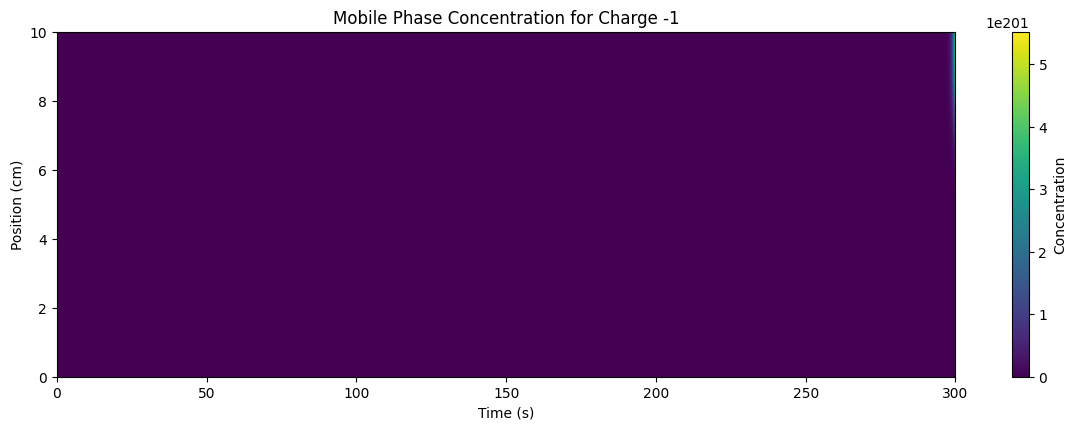

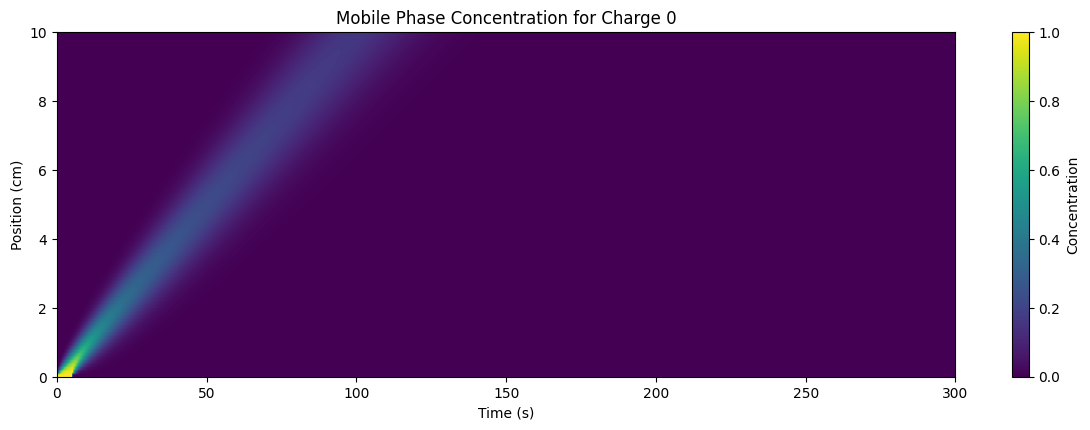

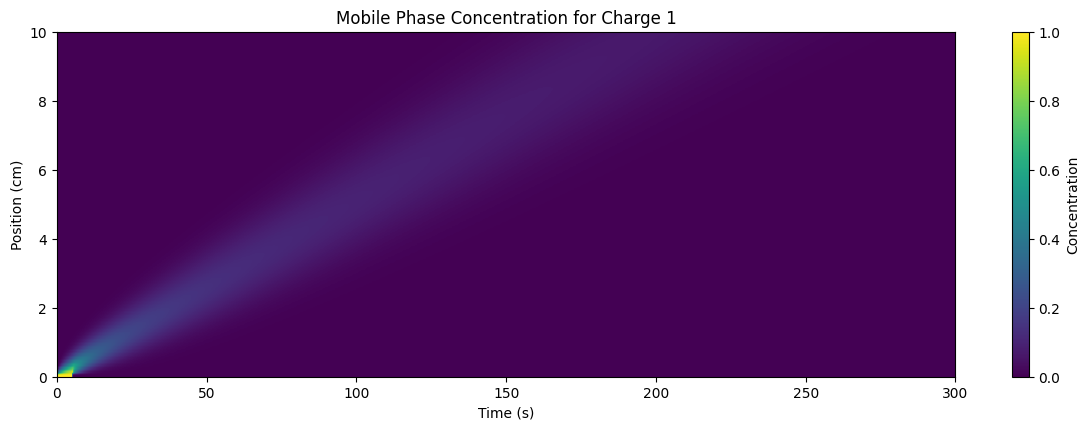

In [ ]:
#faire aussi simu basique
import numpy as np
import matplotlib.pyplot as plt

class ChromatographySimulation:
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, charges, retention_factors):
        self.L = L  # Length of the column
        self.T = T  # Total time
        self.v = v  # Linear mobile phase velocity
        self.D = D  # Diffusion coefficient
        self.Nx = Nx  # Number of spatial grid points
        self.Nt = Nt  # Number of time steps
        self.dx = L / Nx  # Spatial step size
        self.dt = T / Nt  # Time step size
        self.pulse_duration = pulse_duration
        self.pulse_concentration = pulse_concentration
        self.charges = charges  # List of charges of the molecules
        self.retention_factors = retention_factors  # Retention factors for the molecules

        self.c = np.zeros((len(charges), Nx))  # Mobile phase concentration for each molecule
        self.cp = np.zeros((len(charges), Nx))  # Pore phase concentration of free molecules for each molecule

        self.z = np.linspace(0, L, Nx)
        self.c_history = []
        self.cp_history = []

    def R(self, c, cp, charge, retention_factor):
        return  (c - cp) * charge

    def simulate(self):
        for n in range(self.Nt):
            t = n * self.dt
            for i in range(len(self.charges)):
                charge = self.charges[i]
                retention_factor = self.retention_factors[i]

                J = -self.D * np.gradient(self.c[i], self.dx)
                N = self.v * self.c[i] + J

                dc_dt = -np.gradient(N, self.dx) - self.R(self.c[i], self.cp[i], charge, retention_factor)
                dcp_dt = self.R(self.c[i], self.cp[i], charge, retention_factor)

                self.c[i] += dc_dt * self.dt
                self.cp[i] += dcp_dt * self.dt

                if t <= self.pulse_duration:
                    self.c[i][0] = self.pulse_concentration

                else:
                    self.c[i][0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())

    def plot_results(self):

        for i in range(len(self.charges)):
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 1, 1)
            plt.title(f'Mobile Phase Concentration for Charge {self.charges[i]}')
            plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
            plt.colorbar(label='Concentration')
            plt.xlabel('Time (s)')
            plt.ylabel('Position (cm)')

            plt.tight_layout()
            plt.show()

# Parameters
L = 10.0
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 1000
pulse_duration = 5
pulse_concentration = 1
charges = [-1, 0, 1]  # Example charges for different molecules
retention_factors = [0.1, 0.1, 0.1]  # Example retention factors

# Create simulation instance
simulation = ChromatographySimulation(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, charges, retention_factors)
simulation.simulate()
simulation.plot_results()

## TEST